## Using mpmath to diagonalize matrices in high precision
In the code cell below, we check the backend that mpmath is using. The gmpy backend is supposed to be faster than the native python backend.

In [1]:
import mpmath.libmp
mpmath.libmp.BACKEND

'gmpy'

If the cell above yields anything other than 'gmpy', install the gmpy2 package using pip or conda. In addition, it might be useful to install the taqaddum (tqdm) package for the progress bar.

Now, let us set the precision to 100 places of decimal.

In [2]:
from mpmath import *
mp.dps=100
mp.pretty=True
print(mp)

Mpmath settings:
  mp.prec = 336               [default: 53]
  mp.dps = 100                [default: 15]
  mp.trap_complex = False     [default: False]


How long does getting the eigenvalues of a $10\times 10$ random matrix take? On my laptop with Intel Core i7 Coffee Lake, it took 136 milliseconds. 

In [3]:
%%time
A = randmatrix(10)
E, ER = mp.eig(A)
#print("Matrix:")
#mp.nprint(A)
print("Eigvals:")
mp.nprint(E)

Eigvals:
[(5.06465 - 4.85362e-103j), (-0.723605 - 0.325042j), (-0.723605 + 0.325042j), (1.15189 - 2.02759e-102j), (-0.110742 - 0.535592j), (-0.110742 + 0.535592j), (0.0484794 - 0.375032j), (0.0484794 + 0.375032j), (0.536256 + 0.056318j), (0.536256 - 0.056318j)]
CPU times: user 136 ms, sys: 519 µs, total: 136 ms
Wall time: 136 ms


Now, let's profile the times for larger matrices. Below I took a bunch of slightly larger matrix sizes and profiled their diagonalization runtimes. I parallelized the iteration over the different matrices for speed.

In [16]:
import timeit
from tqdm import tqdm
from multiprocessing import Pool
nprocs = 4

setup = '''
from mpmath import mp, randmatrix
mp.dps=70
mp.pretty=True
'''

def get_exec_times(s):
    return min(timeit.Timer(f'A = randmatrix({s});E,ER = mp.eig(A)', setup=setup).repeat(7, 10))

matsizes = [2, 12, 50, 4, 16, 44, 28, 36, 20, 8, 55, 60]
with Pool(nprocs) as p:
    exec_times = p.map(get_exec_times, tqdm(matsizes))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 10311.75it/s]


Theoretically, the computational effort for getting the eigenvalues of a square matrix of size $N\times N$ scales as $N^3$. If we do a $\chi^2$ fit to a cubic function, we can estimate the execution time for larger matrices by extrapolation. 

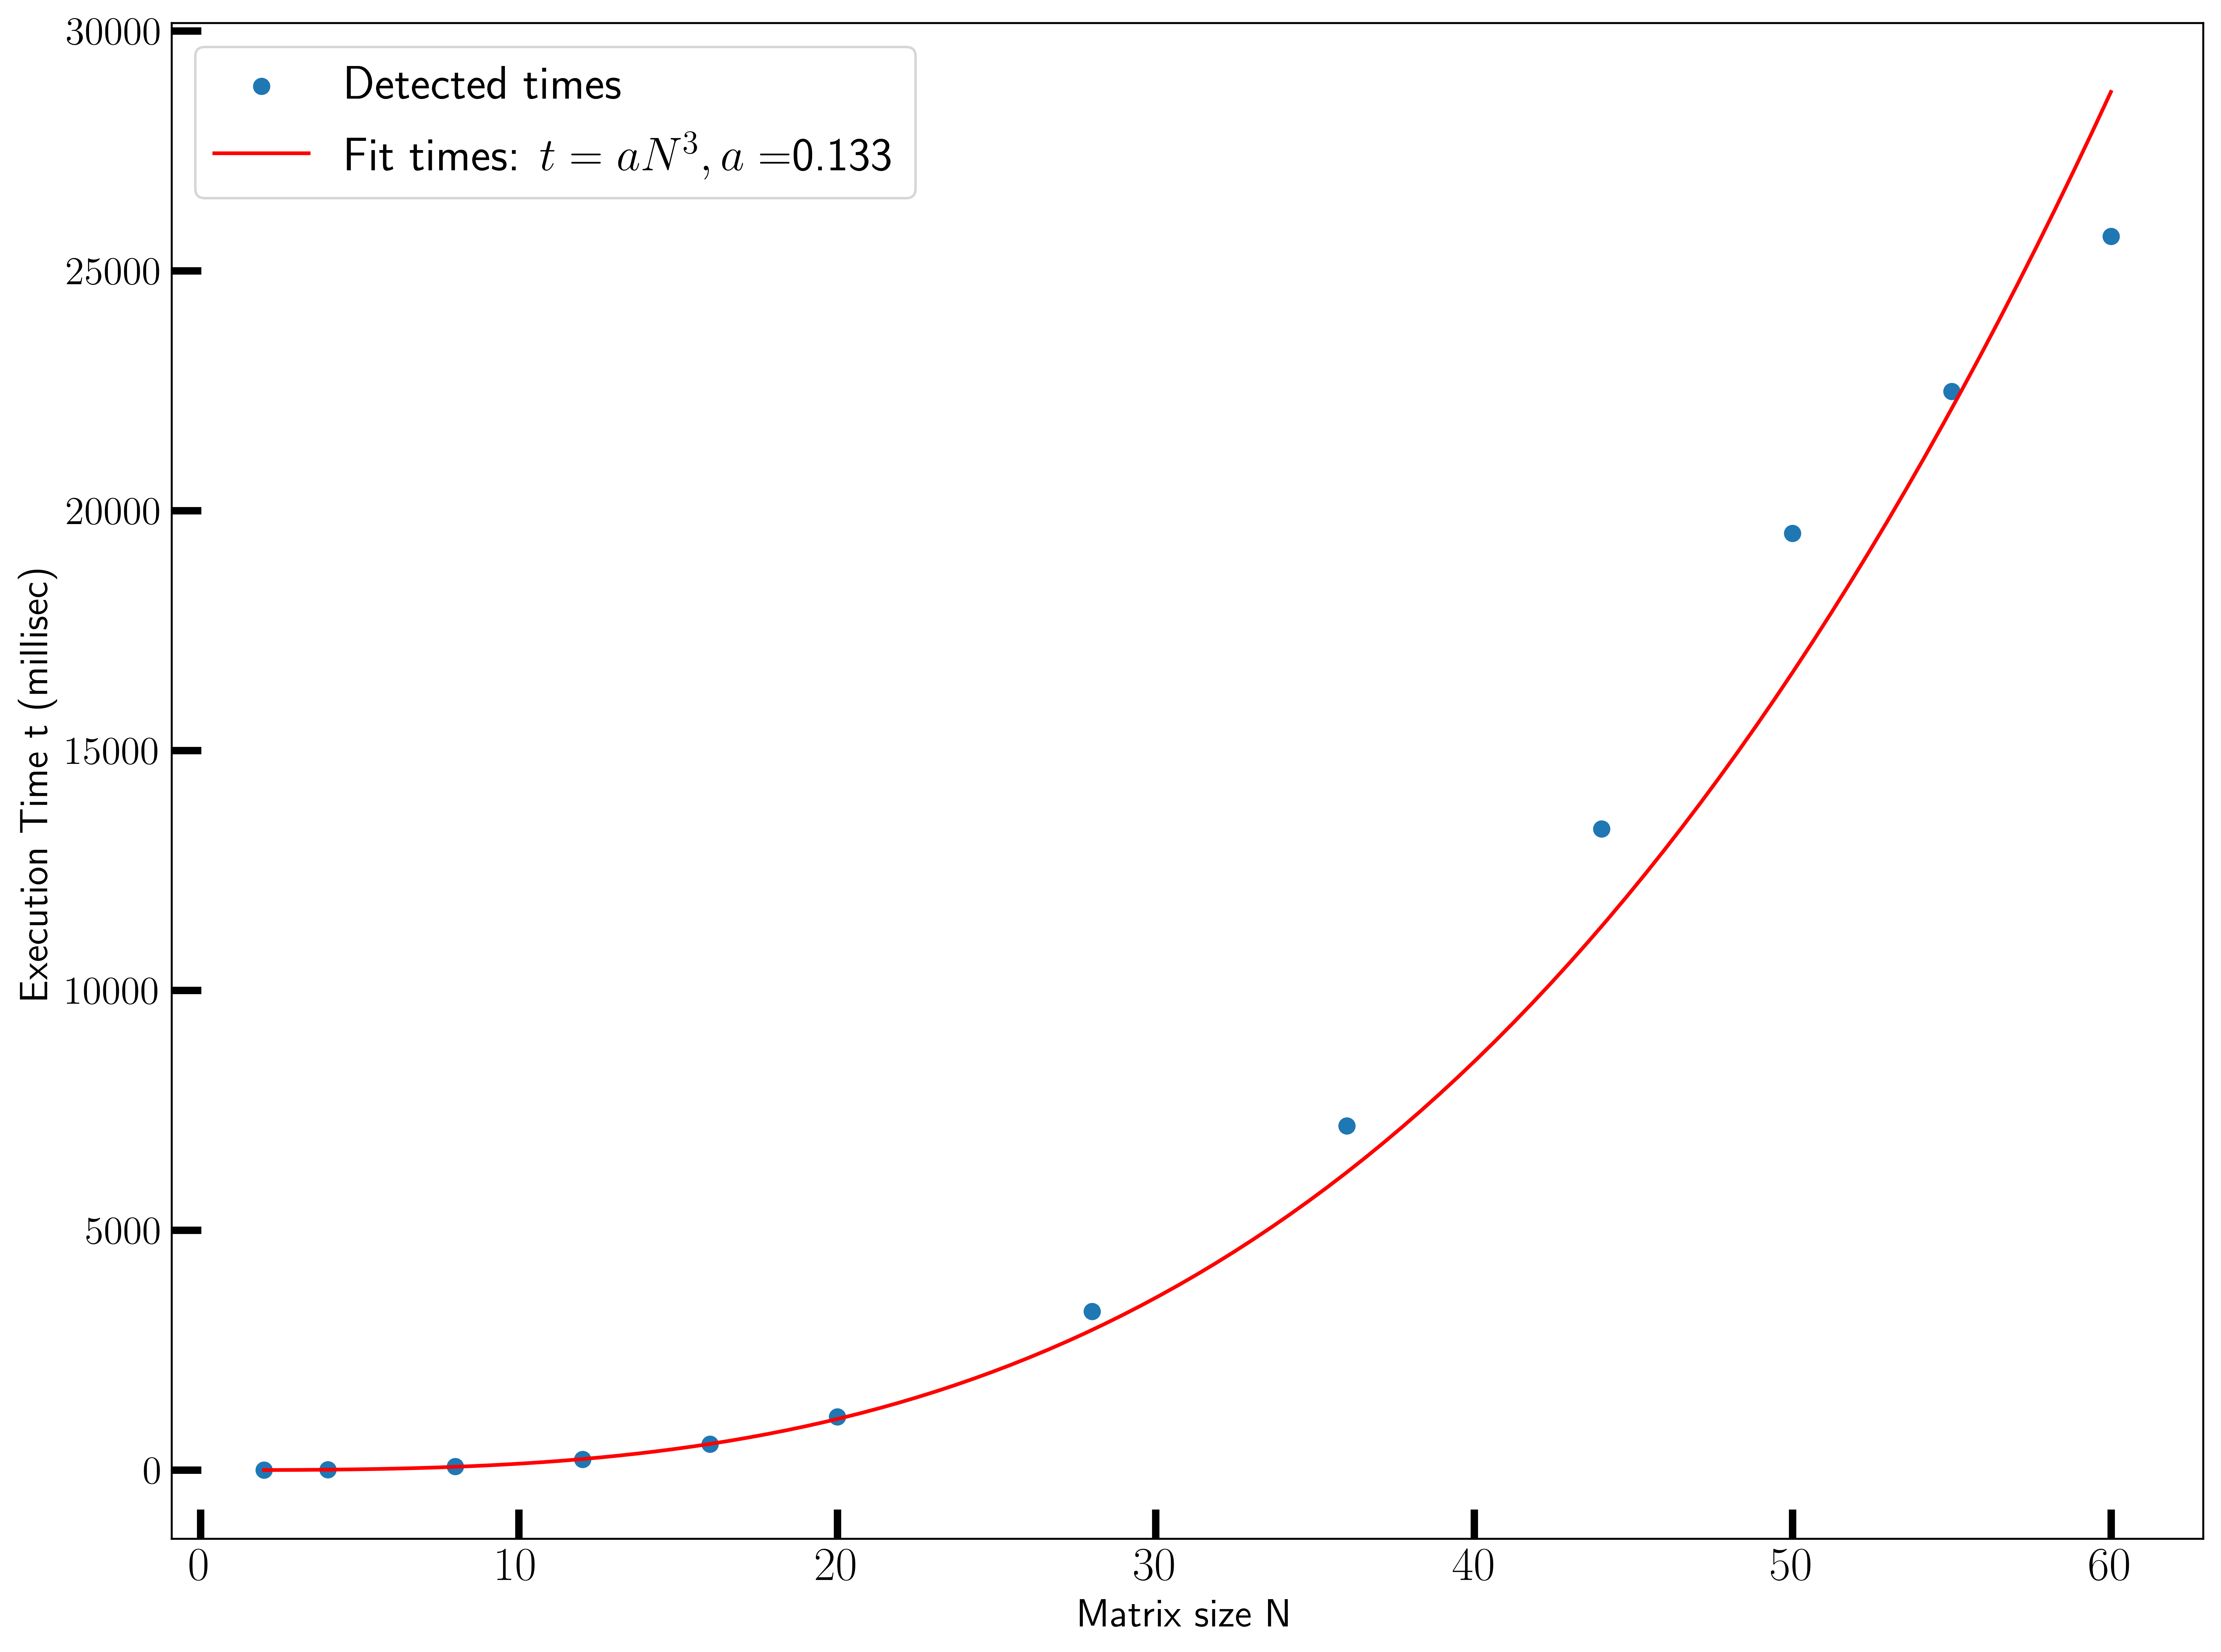

The time it takes to obtain eigenvalues of a 256 X 256 matrix should                                                    be around 37.19338490003844 mins


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def fit_times(x, a):
    return a * x**3

xdata = np.array(matsizes)
ydata = np.array(exec_times) * 100
popt, pcov = curve_fit(fit_times, xdata, ydata)

plt.scatter(xdata, ydata, label="Detected times")
xdata = np.linspace(xdata[0], xdata[-1], 100)
plt.plot(xdata, fit_times(xdata, *popt), 'r-',
         label=fr'Fit times: $t = a N^3, a=${popt[0]:1.3f}')
plt.xlabel("Matrix size N")
plt.ylabel("Execution Time t (millisec)")
plt.legend()
plt.show()

N=256
print(f"The time it takes to obtain eigenvalues of a {N} X {N} matrix should\
                                                    be around {popt[0]*N**3/(60*1000)} mins")